# Tradational Method

In tradational method, the source sends the data to the destination, the destination is then responsible for all the six phases of the sentiment analysis. To create a setup to get results of tradational setup of 1 source and 1 destination have a direct connection follow the following file.

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,rjain116_0000108671
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


In [2]:
slice_name = "check" + fablib.get_bastion_username()

node_conf = [
    {'name': "source", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']},
    {'name': "destination", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}
]

net_conf = [
    {"name": "net0", "subnet": "10.0.0.0/24",
     "nodes": [{"name": "source", "addr": "10.0.0.1"}, {"name": "destination", "addr": "10.0.0.2"}]}
]

route_conf = [
    {"addr": "10.0.1.0/24", "gw": "10.0.0.2", "nodes": ["source"]},
    {"addr": "10.0.2.0/24", "gw": "10.0.1.2", "nodes": ["destination"]},
]

exp_conf = {'cores': sum([n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf])}

In [3]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)
    

You don't have a slice named checkrjain116_0000108671 yet.
Continue to the next step to make one.


In [4]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,EDC
State,Active
Address,"1725 S Oak St.,Champaign, IL 61820"
Location,"(40.09584003877901, -88.24153692109071)"
Hosts,1
CPUs,2
Cores Available,228
Cores Capacity,256
Cores Allocated,28
RAM Available,894
RAM Capacity,1006


'<pandas.io.formats.style.Styler object at 0x7ffaf7c9f040>'

In [5]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [6]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

In [7]:
slice.submit()


Retry: 8, Time: 221 sec


ID,3ef2da31-780c-403f-afc2-e09278b921a5
Name,checkrjain116_0000108671
Lease Expiration (UTC),2023-12-08 19:39:39 +0000
Lease Start (UTC),2023-12-07 19:39:39 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
d26cab77-93dc-4100-be9b-6e25b8d67378,destination,2,4,10,default_ubuntu_22,qcow2,edc-w1.fabric-testbed.net,EDC,ubuntu,2620:0:c80:1003:f816:3eff:fe41:de5c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe41:de5c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
7cb32bdc-d083-4d6e-8196-32890cf3c659,source,2,4,10,default_ubuntu_22,qcow2,edc-w1.fabric-testbed.net,EDC,ubuntu,2620:0:c80:1003:f816:3eff:fe35:2a2,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe35:2a2,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
5715b176-e451-4ace-8c3e-d72764e7b69d,net0,L2,L2Bridge,EDC,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
source-net0-p1,p1,source,net0,100,config,,06:21:AE:E3:FE:F0,ens7,ens7,None,6
destination-net0-p1,p1,destination,net0,100,config,,06:70:14:5E:A2:01,ens7,ens7,None,6



Time to print interfaces 224 seconds


'3ef2da31-780c-403f-afc2-e09278b921a5'

In [8]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

In [9]:
slice = fablib.get_slice(name=slice_name)

In [10]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [11]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [12]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.0.0.1 source
10.0.0.2 destination
10.0.0.1 source
10.0.0.2 destination


In [13]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [14]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

In [15]:
slice = fablib.get_slice(name=slice_name)

l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

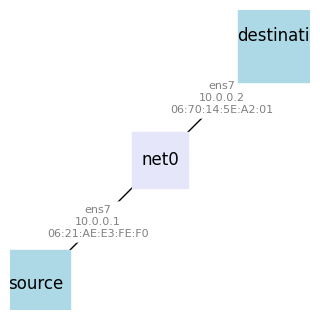

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [18]:
import pandas as pd

slice = fablib.get_slice(name=slice_name)


pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
source,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe35:2a2
destination,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe41:de5c


In [ ]:
slice = fablib.get_slice(slice_name)

slice.get_node("source").upload_file("/home/fabric/work/TradationalMethodFiles/senderMultiInterface.py", "/home/ubuntu/sender.py")
slice.get_node("destination").upload_file("/home/fabric/work/TradationalMethodFiles/destination.py", "/home/ubuntu/destination.py")


## Execution

Now, SSH into the source and destination and follow the steps:
1. In source and destination node terminal, install the required packages.
2. In the destination node terimal, run the command "python3 ./destination.py".
3. In the dource node terminal, run the command "python3 ./sender.py"

After successful sending of packets, you will get a map of unique Id's and timestamp at which the packets were sent by the source, copy this map in file GetTimeDifPhase2.ipynb.

After 20 seconds, the desination will stop sniffinf for packets, it will also output a map of unique Id's and timestamp, these timestamp are the values at which the sentiment analysis value was available to the destination node. Copy this map into the second map of GetTimeDifPhase2.ipynb.

Now execute the code in GetTimeDifTradational.py. You will get the time difference and average time it took for the destination to get the sentiment value.

In our run, we got an average time of 7797.51 milliseconds.